


# <center>Codes for Homework4_IFT6390(Kaggle Competition)</center>

<center>Qiang Ye (20139927),  Lifeng Wan (20108546),  Jinfang, Luo(20111308)</center>

<center>Team Name on Kaggle: YLW_IFT6390_UdeM</center>

<center>Last Modified: 1 december 2018</center>



## Introduction
This .ipynb is for the Kaggle in-class competition: "Quick Draw". 

The codes is designed to run on google Colab with GPU computation platform, yet it also works on local machine with only CPU supported. 

Before running this .ipynb file, you should download the training and testing data and put them in a folder:

1. go to https://www.kaggle.com/c/ift3395-6390-f2018, download 4 data files: `train_images.npy`, `train_labels.csv`, `test_images.npy`, and `sample_submission.csv`, 
2. create a new folder named "input" in the directory where this .ipynb file is, 
3. put the 4 files into the folder created.

`pytorch 0.4.1` is chosen as our machine learning modules; besides, codes are also relied on the following basic python libraries:
 - python 3.5.2, 
 - numpy 1.14.2 
 - matplotlib 2.2.0, 
 - torchvision 0.2.1
 
Some other modules are also used yet not fully listed here.

The whole .ipynb is divided into the following 11 sections:

- Support for Codes Running on Colab with GPU
- Necessary Modules & Basic Tool Functions
- Loading Original Data
- Baseline model - Linear SVM
- Data Pre-Processing
- Data Augmentation
- Models
- Preparation for Training Competitative Models
- Training Models
- Performance Analysis
- Testing Models on Test Dataset

The first section gives us an access to use the Colab platform with high speed computation. If you encounter errors when running codes in this section, the following link could help you:
- https://colab.research.google.com/
- https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

The second section imports basic modules required and use GPU resources if available. If error occurs in this section, it is probably because some modules are not installed. If GPU is not available, CPU will be used. 

From the thrid section until to the end of the file, we built our codes by first implementing some methods, then use some codes to test and show the outputs of the methods to make sure these methods are well functioned. A global bool variant `SHOW_DEMO` is used to open or close these code blocks which is somehow like:

    if USE_DEMO:
        # codes here
        pass
        
We recommend you set `SHOW_DEMO = True` for the first time running this .ipynb, such that you have a good understanding of the role of each method we implemented. After you have a clear idea of all the methods, you may use `SHOW_DEMO = False` to skip all check codes, focusing on the section: **Training Models**, select **run before** in your notebook menus, and start  training a model.

Without further due, let's start by executing the first code cell(line):

In [0]:
SHOW_DEMO = False

## 1. Support for Codes Running on Colab with GPU

The following codes help to run this .ipynb on google colab computation platform. If you run this .ipynb on your local machine, ignore the codes in this section.



In [0]:
# instruction of using colab python 
# https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

Mount drive on google drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
# 4/oQAe5a98SL9kZzGrY2QyFGlcPFGy4wN4gZZ1O8R4y4zXhhJWJ0KnGT4

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Redirect to current working directory

In [4]:
import os
os.chdir("drive/My Drive/Colab Notebooks/")
#check if you are in the right directory
!ls

 candidates			 hw4.ipynb
 cnn_nets.py			 HW4_ResNet.ipynb
 Codes_HW4_IFT6390_Final.ipynb	 input
'Copy of hw4_IFT6390.ipynb'	 models
 fastai.ipynb			 Read_Me.ipynb
 HW4-11272055.ipynb		'Report of Homework4_ML.ipynb'
 HW4_1127Bagging.ipynb		 Sophie
 HW4_1128Bagging.ipynb		 submissions
'hw4 (1).ipynb'			 Untitled0.ipynb
 hw4_IFT6390.ipynb


## 2. Necessary Modules & Basic Tool Functions

Load modules necessary and frequently used here, try to use GPU if available.

In [5]:
import numpy as np
from __future__ import print_function, division
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from scipy.ndimage import rotate

# use GPU as priority if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
else:
    device = torch.device('cpu')
    use_cuda = False
    
torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

cuda


We built two basic and very useful tool functions here: function `debug` plays similar roles as python's builtin function: `print`; function `print_progress` displays progress for some time-comsuming procudures, which provides a user-friendly user interface.


In [0]:
# We built two functions: `debug` and `print_progress` for debugging during 
# development and show training progress respectively.

DEBUG = True
def debug(*args, **kwargs):
    global DEBUG
    if DEBUG:
        print(*args, **kwargs)
        

def print_progress(i, time_elapsed = None, before = "progress:", after = ""):
    """show progress of process, often used in training a neural network model
    params
        i: progress value in [0, 1.], double
        time_elapsed: time elapsed from progress 0.0 to current progress, double
        before: descriptive content displayed before progress i, str
        after: descriptive content displayed after progress i, str
    """
    if time_elapsed is not None:
        if i >= 1:
            time_remaining = 0
        elif 0 < i < 1:
            time_remaining = time_elapsed * (1. - i) / i
        else:
            time_remaining = float('inf')
            
    progress_info = '{:>7.2%}'.format(i) # align right, 7 characters atmost
    if time_elapsed is not None:
        progress_info += ' {:.0f}m{:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60)
        if 0 < i < 1.0:
            progress_info += ' {:.0f}m{:.0f}s'.format(
                time_remaining // 60, time_remaining % 60)

    # display progress repeately in the same line.
    progress_info = '\r' + before + progress_info + after
    sys.stdout.flush()
    sys.stdout.write(progress_info)

We also created two folders to manager the intermediate files: models and submissions.

In [0]:
# build two directories for saving model and submission files.
folders = ['./models', './submissions']
for i in range(len(folders)):
    if not os.path.exists(folders[i]):
        debug("creat")
        try:
            debug("creating folder: '{}'. ".format(folders[i]), end = "")
            os.mkdir(folders[i])
            debug("success.")
        except():
            debug("failure.")       

## 3. Loading Original Data

### loading image labels from a file path

Method `load_label_dataset` receives a file path and returns a tuple: `image_labels, int_to_label, label_to_int`. The first variable is a `list` keeping the  true output label data of all training images; the latter two are dicts mapping a image label from `int` to `str` for better understanding the labels and computation efficiency when needed.

Method `view_data_distribution` helps to view the numbers of each class in a dataset, which is sometimes a better debug tool when predicting on test dataset.

In [0]:
def load_label_dataset(file_path = './input/train_labels.csv'):
    # ensure the training labels data are accessible by the path in next line
    image_labels_path = './input/train_labels.csv'
    debug("loading training labels from file: '{}''".format(image_labels_path))
    image_labels_data = np.genfromtxt(image_labels_path, names=True, delimiter=',',
                        dtype=[('Id', 'i8'), ('Category', 'S16')])
    debug("size of image labels:", image_labels_data.shape[0])
    
    sample_size = image_labels_data.shape[0]
    image_labels = np.zeros((image_labels_data.shape[0], ), dtype = np.long)
    
    # 2 dicts store the mapping from class id(int) to labels(str), vice versa.
    label_to_int, int_to_label = {}, {}
    label_i = 0 # first label index
    for i, train_label in image_labels_data:
        train_label = train_label.decode("utf-8")
        if label_to_int.get(train_label) is None:
            label_to_int[train_label] = label_i
            image_labels[i] = label_i
            label_i += 1
        else:
            image_labels[i] = label_to_int[train_label]

    for key, value in label_to_int.items():
        int_to_label[value] = key   

    n_class = len(int_to_label) # constant. number of classes

    #debug("first 100 samples in image_labels:", image_labels[0:100])
    debug("dict from int to label", int_to_label)
    debug("dict from label to int", label_to_int)
    debug("train labels shape:", image_labels.shape)
    debug("number of classes = ", n_class)
    
    return image_labels, int_to_label, label_to_int


def view_data_distribution(image_labels, desc, int_to_label):
    if isinstance(image_labels, list):
        image_labels = np.array(image_labels)
    labels = image_labels.astype(int).reshape(-1, )
    label_samples = np.bincount(labels)
    sample_size = len(labels)
    n_class = len(label_samples)
    print("Distribution of: ", desc)
    print("classes:{} total: {:>3} (100%) ".format(n_class, sample_size))
    print("-"*32)
    for i in range(len(label_samples)):
        print("{:>16s}: {:<3} ({:.2%})".format(
            int_to_label[i], label_samples[i], label_samples[i]/sample_size))
    print("-"*32)        
    

In [0]:
# ensure the training labels data are accessible by the path in next line
if SHOW_DEMO:
    image_labels, int_to_label, label_to_int = load_label_dataset()

In [0]:
if SHOW_DEMO:
    view_data_distribution(image_labels, "image_set", int_to_label)

### loading original training images from a file path

Original image data is loaded by the following cell. Once the original image data are loaded, it will be pre-processed by noise reduction and data washing to reduce the noise in the images and remove some unreasonable images from the dataset.

In [0]:
# ensure the training images data are accessible by the path in next line
def load_image_dataset(file_path = './input/train_images.npy'):
    debug("loading training images from file: '{}'... ".format(file_path))
    images_data_original = np.load(file_path, encoding = 'latin1')
    debug("successful")
    image_data = np.vstack(images_data_original[:, 1]) # original train X
    X_original = image_data
    debug("shape of original training X(images): ", X_original.shape)
    return image_data

In [0]:
if SHOW_DEMO:
    X_original = load_image_dataset()

### visualizing image data 

Visualizing the images is very important for us to check if a fucntion is giving the result we expect, especially in data pre-processing and result analysis procedures. Function `show_images` receive one or a set of dataset with the same sample size and labels(if known), display all images, each from one dataset, with an image id randomly selected or user demandes. If a class_name or class id is specified, the `img_id` parameter will be ignored, and only the images of that class will be randomly selected to display.

In [0]:
def show_images(Xs, 
                labels = None,  
                img_id = None, 
                class_id = None, 
                class_label = None,
                is_test = False,
                label_to_int = None
               ):
    """show image(s) with a certain index in a list of dataset in a line.
    Params
        Xs: list of dataset, example: [X_original, X_resized], 
            usually all the dataset in the list have the same labels.
        labels: labels of dataset X,  narray (size, 1) or (size, )
        img_id: index of image to be displayed in the dataset, 
            if img_id is None, randomly select an image id from datasets.
        class_id: specify the class_id of image will be displayed, if image
            with img_id conflict with class_id, class_id has priority
        class_label: name of a class, str
        label_to_int: dict(map) from class name to class_id
        is_test: indicating whether the image in a test image
    """
    if not isinstance(Xs, list): # support single dataset.
        Xs = [Xs]
    if (class_id is not None or class_label is not None) and labels is None:
        # need labels to select images with certain class_id
        raise ValueError("need labels should if class_id is not None")
        
    n_imgs = len(Xs) # type of images to display
    plt.figure(figsize = (3*(n_imgs + 1), 3))
    rnd = 0 # default image index is 0
    rdn = img_id if img_id is not None else np.random.randint(0, Xs[0].shape[0])
    
    # if both id and class_id is not None, class_id has priority
    if class_id is not None or class_label is not None:
        class_id = class_id if class_id else label_to_int[class_label]
        indices_with_class_id = np.where(labels == class_id)[0]
        rdn = np.random.choice(indices_with_class_id)
    
    if labels is not None and is_test is False:
        debug("image id:{}, class_id:{}, class_label:{}".format(
            rdn, labels[rdn], int_to_label[labels[rdn]]))
    else:
        debug("id:{}".format(rdn))
        
    for i, X in enumerate(Xs):
        if X is not None:
            plt.subplot(1, n_imgs, i+1)
            size = int(np.sqrt(X.shape[1]))
            plt.imshow(X[rdn].reshape(size, size), cmap='gray')
    plt.show()

In [0]:
if SHOW_DEMO:
    show_images(X_original, image_labels, img_id = None, 
                class_label = "squiggle", label_to_int = label_to_int)

## 4. Baseline model - Linear SVM
.

In [0]:
# set this True to run the Linear SVM classifier
RUN_LINEAR_SVC = False

if RUN_LINEAR_SVC:
    from sklearn.model_selection import train_test_split 
    from sklearn.svm import LinearSVC

    train_X, test_X, train_y, test_y = train_test_split(X_original, image_labels, test_size=0.25, random_state=42)

    clf = LinearSVC(random_state=0)
    print(clf)
    clf.fit(train_X, train_y)  
    pred_svm = clf.predict(test_X)

    valid = np.mean(pred_svm == test_y)
    print("The accuracy is {:.2f}%".format(100*valid))


## 5. Data Pre-Processing

### noise reduction

Assuming a meaningful picture will have the largest number of connected pixels(region)if it exists n a training image sample with background noises, . If we can find this largest connected points, the noise on this image can be easily removed. 

Several alogrithms can be used to find this largest connected pixels(region), such as deep first search(DFS) and density based scan(DBSCAN). Here, we implemented this function using both DFS and DBSCAN algorithms. For DBSCAN algorith, we chose the parameter `epsilon` = 1, and `min_samples` = 2. Both methods almost have the same effects reducing the noise of our dataset.

1). using DFS to get a maximal connected point list

In [0]:
# methods and class to reduce noise using DFS algorithm
class DFS:
    """a deep first search class 
    """
    def __init__(self, my_shape, matrix): 
        """
        params
            my_shape: shape of search region, tuple or list size of 2
            matrix: search region data. narray (my_shape)
        """
        self.row = my_shape[0]
        self.col = my_shape[1]
        self.matrix = matrix
        
        
    def _is_safe(self, i, j, visited): 
        return (i >= 0 and i < self.row and 
                j >= 0 and j < self.col and 
                not visited[i, j] and self.matrix[i, j] > 0)
    
    
    def get_all_neighborhood(self, i, j, visited, points):
        """get all points connected to point [i, j]
        Params
            i, j: row and col index of a given point, int, int
            visited: mark whether a point is visited or not, narray
            points: connected neighbors of point [i, j],list
        Returns
            points: 
        """
        points.append((i, j))
        visited[i, j] = True
        nbrs_row = [-1, -1, -1,  0, 0,  1, 1, 1]; 
        nbrs_col = [-1,  0,  1, -1, 1, -1, 0, 1];   
        # Recur for all connected neighbours 
        for k in range(8): # max neighbor numbers
            if self._is_safe(i + nbrs_row[k], j + nbrs_col[k], visited): 
                self.get_all_neighborhood(i + nbrs_row[k], j + nbrs_col[k], 
                                          visited, points)
        return points
    
    
def get_region_size(matrix, row, col):
    """this function changes the original data of matrix for specific purpose.
    this function is also a recursive function.
    """
    if row < 0 or col < 0 or row >= len(matrix) or col >= len(matrix[row]):
        return 0
    if matrix[row, col] == 0:
        return 0
    matrix[row, col] = 0 # avoid repeated counting
    size = 1
    for r in range(row - 1, row + 2):
        for c in range(col - 1, col + 2):
            if r != row or c != col:
                size += get_region_size(matrix, r, c) # recursive
    return size


def get_point_in_biggest_region(matrix, m_shape):
    max_region_size = 0
    rows, cols = m_shape
    x, y = 0, 0
    for r in range(rows):
        for c in range(cols):
            if matrix[r, c] > 0:
                size = get_region_size(matrix, r, c)
                if size > max_region_size:
                    x, y = r, c
                    max_region_size = size
    return x, y    


def find_max_connected_points(img, img_size = (100, 100)):
    img_copy = copy.deepcopy(img)
    x, y = get_point_in_biggest_region(img_copy, img_size)
    dfs = DFS(img_size, img)
    visited = np.zeros(img_size)
    points = dfs.get_all_neighborhood(x, y, visited, [])
    return points

2). using  DBSCAN to get a maximal connected point list

In [0]:
# methods using DBSCAN to reduce noise
from sklearn.cluster import DBSCAN

def build_db_X(img, img_size = (100, 100)):
    """generate traing set X as a DBSCAN training set from an image with 
    certain size.
    params
        img: a sample from training image data, narray (100, 100) or (10000, )
    returns
        narray: indicating the row and col indices of non-zeor pixel, (-1, 2)
        [[1, 2],
         [1, 5],
         [33, 25],
         ...
        ]
        where [1, 2] is the row and col indices where a first non-zero pixel is
    """
    img = img.reshape(img_size)
    xs, ys = np.nonzero(img)
    return np.hstack((np.array(xs).reshape(-1, 1), 
                      np.array(ys).reshape(-1, 1)))


def find_max_connected_points_DBSCAN(img, img_size = (100, 100)):
    """get max connected region from a dbscan labels
    params
        db_X: training X for dbscan in 2D: (x, y) of non-zero pixel values in a
              (100, 100) original images, narray (non_zero_pixel_num, 2)
        db_labels: labels for each element of db_X, narray (non_zero_pixel_num)
    returns
        a list of (x, y) belong to the largest cluster, except -1(noise)
    """
    db_X = build_db_X(img, img_size)
    clustering = DBSCAN(eps = 1, min_samples = 2).fit(db_X)
    db_labels = clustering.labels_
    has_noise_label = True if -1 in db_labels else False
    if has_noise_label:
        n_clusters = len(set(db_labels)) - 1
        # change the noise label from -1 to a positive number
        db_labels[db_labels == -1] = n_clusters + 1
        # np.bincount cannot handle value with negative int.
    frequent_count = np.bincount(db_labels)
    if has_noise_label:
        # count for noise label is the last element of the list
        # remove the last elment
        frequent_count = frequent_count[0:-1] 
    # find the index of a max frequent_count value, the index is also
    # the label value
    label_max = np.argmax(frequent_count)
    largest_cluster_points = []
    for i, label in enumerate(db_labels):
        if label == label_max:
            largest_cluster_points.append(db_X[i,:])
    return largest_cluster_points

Once a maximal connected point list is achieved from a 2 dimensional image, the boundary of the point list is determined; thus, we uses the pixel values of the region within the boundary to get a noise-reduced image. The following methods are implemented to achieve these objects.

In [0]:
def rebuild_image(points, old_img, img_size = (100,100)):
    """rebuild an noise reduced image based on the cordinates of series of max
    connected points and old image data
    params
        points: a series of cordinates of points in a max connected region, list
                [(x0, y0),(x1, y1),...]
        old_img: old image data, narray (img_size)
        img_size: shape of old image and of new image as well
    returns
        img_target: new image with the same size of old image but noise reduced
    """
    old_img = old_img.reshape(img_size)
    img_target = np.zeros_like(old_img)
    top, down, left, right = get_bounds(points)
    img_target[left:right+1, top:down+1] = old_img[left:right+1, top:down+1]
    return img_target


def get_bounds(points):
    """get the boundary limits of a list of point
    """
    top, down, left, right = 100, 0, 100, 0
    for x, y in points:
        top = y if y <= top else top
        down = y if y >= down  else down
        left = x if x <= left else left
        right = x if x >= right else right
    return top, down, left, right

Therefore, we have all the tools needed to implement a method `reduce_noise` to reduce the noise of the whole image dataset. 

As reducing noise is a time consuming procedure, we may not want to repeat this procedure every time we load the original image data. The natural way is to save the noise reduced data to hard drive and load it when necessary. 

Therefore, we built a method to load the data from a file path . if succeeded, we use the data loaded, if not, we perform `reduce_noise` to transform the original data to noise reduced data.

In [0]:
def reduce_noise(X, 
                 img_size = (100, 100),
                 max_connected_points_func = find_max_connected_points):
    """reduce noise of a image dataset
    params
        X: a image dataset, 2D narray, (sample_size, img_pixels)
        img_size: image shape, tuple (heigh, width)
        max_connected_points_func: function using to find max connected points
    returns:
        X_copy: image dataset, shape like X, with noise reduced
    """
    # some function (get_region_size) changes original data as parameters.
    X_copy = copy.deepcopy(X)
    debug("using func: '{}'".format(
        max_connected_points_func.__name__))
    since = time.time()
    for i, x in enumerate(X_copy):
        img = x.reshape(img_size)
        points = max_connected_points_func(img, img_size)
        img_target = rebuild_image(points, img, img_size)
        X_copy[i] = img_target.reshape(-1, )
        time_elapsed = time.time() - since
        print_progress((i+1)/len(X_copy), time_elapsed)

    return X_copy


# useful function to load data from local drive
def data_from_file(file_path = None, 
                   description = "",
                   failed_func = None,
                   *args, **kwargs):
    """load numpy array data from a file path
    params
        file_path: where the data locates, str
        description: brief description of the data, str
        failed_func: if loading data failed, the function to executed
        *args, **kwargs: parameters of the failed_func
    returns
        data: loaded or by failed_func. narray
    """
    if file_path is None:
        return None
    try:
        debug("loading '{}' from: '{}'... ".format(
            description, file_path), end = "")
        data = np.load(file_path, encoding = 'latin1')
        debug("successful.")
    except:
        debug("failed.\nperforming: '{}'... ".format(
            failed_func.__name__), end = "")
        data = failed_func(*args, **kwargs)
        debug("successful.\nsaving data to: '{}'... ".format(
            file_path), end = "")
        np.save(file_path, data)
        debug("complete.")
    debug("shape of '{}': {}".format(description, data.shape))
    return data

Run the following cell to see how the above methods work.

In [0]:
if SHOW_DEMO:
    file_X_noise_reduced = './input/noise_reduced_train_X.npy'
    X_noise_reduced = data_from_file(file_X_noise_reduced, 
                                 "noise reduced",
                                 reduce_noise,
                                 X_original,
                                 img_size = (100, 100)
                                )

This code shows the original and noise reduced forms of an random selected image from a certern image class.

In [0]:
if SHOW_DEMO:
    show_images([X_noise_reduced, X_original], image_labels, 
            class_label = "screwdriver", label_to_int = label_to_int)

This code shows the original and noise reduced forms of an image with the id = 5473.

In [0]:
if SHOW_DEMO:
    show_images([X_noise_reduced, X_original], image_labels, 
                img_id = 5473, label_to_int = label_to_int)

### resizing image

As we can see, an noise reduced image occupies only a small area of a region with 100 × 100 pixels. Brieftly statistics show that most of the noise reduced image are within the size 30 × 30 pixels. 

Although we can directly feed image with size (100 × 100) to a classifier, it's much better to crop the blank area surrounding the meaningful image and resize it to a small size such as: 30 × 30. 

This work can be completed by the methods implemented in the following code cell. 

In [0]:
from skimage.util import pad
from skimage.transform import resize

def crop_img(img):
    """cut off the black area surrounding non-zero pixels. 
    params
        img: image to be cropeed, 2d narray
    returns:
        cropped image, 2d narray
    """
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return img[rmin: rmax + 1, cmin: cmax + 1]

def my_resize(img, size = (30, 30)):
    """resized img will keep its resolution and will be centered if smaller 
    than original img.
    """
    height, width = img.shape
    ratio = max(height / size[0],  width / size[1])
    if ratio > 1:
        new_size = (int(img.shape[0] / ratio), int(img.shape[1] / ratio))
        resized = resize(img, new_size, mode = 'reflect')
    else:
        resized = img
    pad_left = int((size[1] - resized.shape[1])/2)
    pad_right = size[1] - pad_left - resized.shape[1]
    
    pad_top =  int((size[0] - resized.shape[0])/2)
    pad_bottom = size[0] - pad_top - resized.shape[0]
    pads = ((pad_top, pad_bottom), (pad_left, pad_right))
    resized = np.pad(resized, pads, 'constant', constant_values = 0)
    return resized

def resize_dataset(X, old_size = (100, 100), new_size = (30, 30)):
    """resize the dataset X, from old_size to new_size
    """
    debug("resizing images... ")
    n_size = len(X)
    resized_X = np.zeros((n_size, new_size[0] * new_size[1]))
    since = time.time()
    for i, x in enumerate(X):
        img = x.reshape(old_size)
        img = crop_img(img)
        resized_X[i] = my_resize(img, size = new_size).reshape(-1, )
        time_elapsed = time.time() - since
        print_progress((i+1)/len(X), time_elapsed)
    return resized_X

Run the following cell to see how the above methods work.

In [0]:
if SHOW_DEMO:
    file_X_resized = './input/resized_and_noise_reduced_X.npy'
    X_resized = data_from_file(file_X_resized, 
                           "X_resized",
                           resize_dataset,
                           X_noise_reduced,
                           old_size = (100, 100),
                           new_size = (30, 30)
                          )

The following code shows the original, noise reduced and resized form of an image.

In [0]:
if SHOW_DEMO:
    show_images([X_resized, X_noise_reduced, X_original], image_labels)

### normalization
Normalization is also a good choice for data pre-processing.

In [0]:
from sklearn.preprocessing import MinMaxScaler
def normalize_dataset(X):
    debug("normalizing data... ", end="")
    minmax = MinMaxScaler()
    X_norm = minmax.fit_transform(X)
    debug("complete.")
    return X_norm

In [0]:
if SHOW_DEMO:
    # normalization
    use_normalization = True
    if use_normalization:
        X_normed = normalize_dataset(X_resized)

In [0]:
if SHOW_DEMO:
    #show_images([X_normed, X_resized, X_noise_reduced, ], image_labels)
    show_images([X_original, X_noise_reduced, X_resized, X_normed ], image_labels)

In [0]:
if SHOW_DEMO:
    # now X_resized is normalized
    X_resized = X_normed

### merging images and labels

In [0]:
if SHOW_DEMO:
    # merge train_images and labels to one numpy array
    # very important varialbe: train_valid_set
    file_path = './input/pre_processed_train_data.npy'
    train_valid_set = data_from_file(file_path,
                          "train_valid_dataset",
                          np.concatenate,
                          (X_resized, image_labels.reshape(-1, 1)),
                          axis = 1)

In [0]:
if SHOW_DEMO:
    show_images([train_valid_set[:,:-1]], train_valid_set[:, -1])

### washing


Some images are meanless or have no relationship with their class labels. We may drop them. Have a try.

In [0]:
def load_bad_sample_ids(): 
    bad_lists = [None] * 8

    # 1. screwdriver peanut and spoon
    bad_lists[0] = [42, 186, 285, 483, 541, 612, 627, 851, 1045, 1083, 1212,
                    1245, 1438, 1598, 1820, 2199, 2262, 2361, 2517, 2522, 2737,
                    2791, 2846, 2873, 3226, 3452, 3571, 3769, 3780, 4176, 4201,
                    4642, 4749, 4856, 4913, 4988, 5282, 5337, 5642, 5858, 6029,
                    6099, 6378, 6523, 6825, 7129, 7965, 8430, 8645, 8655, 9001,
                    9389
                   ]
    # 2. nail and rabbit
    bad_lists[1] = [38, 124, 128, 164, 303, 368, 384, 478, 550, 693, 727, 749,
                    757, 932, 1093, 1133, 1205, 1214, 1251, 1388, 1400, 1421,
                    1503, 1507, 1661, 1695, 1708, 1778, 1842, 1844, 1853, 1923,
                    2042, 2080, 2120, 2130, 2170, 2184, 2461, 2680, 2796, 3133,
                    3373, 3379, 3381, 3414, 4148, 4212, 4576, 4763, 4831, 5000,
                    5249, 5372, 5447, 5500, 5546, 5967, 6141, 6209, 6283, 6291,
                    6299, 6768, 7017, 7037, 7115, 7119, 7279, 7608, 7684, 7883,
                    7908, 8033, 8141, 8191, 8236, 8282, 8531, 8648, 8746, 8786,
                    8871, 9107, 9218, 9491, 9536, 9651, 9699, 9761, 9957
                   ]
    # bad_list_2 = []
    # 3. panda
    bad_lists[2] = [372, 386, 650, 924, 1333, 2865, 3873, 4018, 4049, 4257, 
                    5229, 5284, 5516, 6300, 7315, 7409, 9712, 9927
                   ]
    # 4. rifle
    bad_lists[3] = [50, 292, 363, 748, 1319, 1382, 1571, 2026, 2764, 3100, 3534,
                    3657, 4088, 4092, 4191, 4719, 4789, 4918, 5086, 5162, 5192,
                    5404, 5989, 6246, 6502, 7013, 7327, 7349, 7557, 8765, 9445, 
                    9564, 9846, 9960
                   ]
    # 5. sink
    bad_lists[4] = [2362, 3196, 3410, 4987, 5121, 5604, 6092, 6462, 7341, 9340,
                    9817
                   ]
    # 6. pear
    bad_lists[5] = [341, 4608, 5329, 7835, 7841]

    # 7. moustache
    bad_lists[6] = [474, 658, 1005, 1363, 1539, 1657, 1893, 2258, 2575, 2709,
                    2912, 3020, 3184, 3466, 4035, 4504, 4742, 4938, 4961, 4986,
                    6024, 6414, 6451, 6677, 7098, 7148, 7235, 7388, 7761, 8476,
                    9737, 9855, 9980
                   ]
    # bad_list_7 = []
    # 8. parrot
    bad_lists[7] = [1221, 2028, 2167, 2387, 3309, 3517, 4142, 4747, 4821, 5873,
                    7154, 7208, 7314, 8569, 8868, 9872
                   ]
    bad_sample_ids = []
    for i in range(8):
        bad_sample_ids.extend(bad_lists[i])
        
    bad_sample_ids = list(set(bad_sample_ids))
    debug("{} samples to be washed out".format(len(bad_sample_ids)))
    return bad_sample_ids

In [0]:
# an image with hand written 'pear' labeld 'pear'
if SHOW_DEMO:
    show_images([X_resized, X_noise_reduced, X_original], image_labels, img_id = 341)

In [0]:
# Pay attention to to source (which dataset) of the indices of bad samples
def wash_samples(data_set):
    """
    params
        bat_sample_ids: [int, int, int, ...]
    """
    bad_sample_ids = load_bad_sample_ids()
    data_set_clean = data_set
    # if you use original data to remove bad samples. do not
    # add your code here
    debug("washing out bad samples...", end = " ")
    data_set_clean = np.delete(data_set, bad_sample_ids, axis = 0)
    debug("complete. current data shape: {}".format(data_set_clean.shape))
    assert data_set.shape[0] - data_set_clean.shape[0] == len(bad_sample_ids),\
        "data length mismatch before and after removing."
    
    return data_set_clean

In [35]:
# using the following code to reload train_valid_set if you wash_samples more than
# 2 times
'''
file_path = './input/pre_processed_train_data.npy'
train_valid_set = data_from_file(file_path,
                          "train_valid_dataset",
                          np.concatenate,
                          (X_resized, image_labels.reshape(-1, 1)),
                          axis = 1)
'''

'\nfile_path = \'./input/pre_processed_train_data.npy\'\ntrain_valid_set = data_from_file(file_path,\n                          "train_valid_dataset",\n                          np.concatenate,\n                          (X_resized, image_labels.reshape(-1, 1)),\n                          axis = 1)\n'

In [0]:
# remove bad samples
# ** CAUTION: **
# This cell shouldn't be run more than 1 time, cause it may delete
# other normal image data or delete a image with the id that donesn't exist。
# Rebuild train_valid_set in the last cell if you unfortunately run this cell
# twice or more

if SHOW_DEMO:
    use_bad_samples_removal = True
    # add your bad sample ids in this list
    if use_bad_samples_removal:
        train_valid_set = wash_samples(train_valid_set)

Run and re-run the following cell to see different images in current dataset

It is always recommended to show some images after some operation. 

In [0]:
if SHOW_DEMO:
    show_images([train_valid_set[:,:-1]], train_valid_set[:, -1])

## 6. Data Augmentation

Several augmentation techniques are used in thie problem, which are: rotation, uniformed noising, flipping etc.

### data split

It's time to split our dataset to **train** and **validate** datasets.

In [0]:
if SHOW_DEMO:
    # change your validate set size here
    n_valid_set = 1000

    # if you do data augmentation, update data_size    
    data_size, n_features = train_valid_set.shape
    n_features -= 1 # cut label 

    valid_start = data_size - n_valid_set # numbers

    # split to train_set and valid_set
    train_set = train_valid_set[0:valid_start,:]
    valid_set = train_valid_set[valid_start:,:]

    debug("shape of train_set: {}".format(train_set.shape))
    debug("shape of valid set: {}".format(valid_set.shape))
    data_size, valid_start, train_end = None, None, None

### rotation

In [0]:
from scipy.ndimage import rotate

def ds_rotate(data_set, degree = 15, img_size = (30, 30)):
    """rotate an image dataset with certain degrees with an image size
    params
        data_set: image dataset with a label, narray (size, n_feature + 1)
        degree: int, -360 - 360, usually use -15 - 15
        img_size: current and rotated image size
    returns
        data_set_rotated: narray (size, n_feature + 1), label unchanged        
    """
    data_X = data_set[:, 0:-1]
    data_labels = data_set[:, -1]

    data_X_rotated = rotate(
        data_X.reshape(-1, img_size[0], img_size[1]),
        degree, axes = (1,2), reshape = False)
    data_X_rotated = data_X_rotated.reshape(
        -1, img_size[0] * img_size[1])
    data_set_rotated = np.concatenate(
        (data_X_rotated, data_labels.reshape(-1, 1)), axis = 1)   
    return data_set_rotated

def augment_with_rotate(data_set):
    """tow degrees 15, -15 are used to augment dataset. return the image 
    rotated dataset, not include the original dataset.
    """
    degrees = np.array([-15, -10, -5, 5, 10, 15])
    new_set = None
    i, total = 0, len(degrees)
    s_before = "rotating image(special)..."
    since = time.time()
    for degree in degrees:
        temp_set = ds_rotate(data_set, degree)
        if new_set is None:
            new_set = temp_set
        else:
            new_set = np.concatenate((new_set, temp_set), axis = 0)
        
        i += 1
        time_elapsed = time.time() - since
        print_progress(i/total, time_elapsed, s_before)

    debug("complete.")
    return new_set

def sub_set_of_class(class_label, data_set):
    """get a subset from dataset with all samples are of class_label"""
    class_id = label_to_int[class_label]
    indices_with_class_id = np.where(data_set[:,-1] == class_id)[0]
    return data_set[indices_with_class_id, :]

def augment_with_rotate2(data_set):
    """perform a specific augmente with certain degrees for whole dataset
    and some degrees for images with certain labels. return the augmented
    dataset(original dataset not included)"""
    s_before = "rotating image(special)..."
    since = time.time()
    degrees = np.array([-15, -10, -5, 5, 10, 15])
    special_degrees = [-150, -120, -90, -75, -60, -45, 
                        150,  120,  90,  75,  60,  45]
    special_labels = ['peanut', 'spoon', 'shovel', 'screwdriver', 'squiggle',
                      'pencil', 'parrot']
    new_set = None
    total = len(degrees) + len(special_degrees) * len(special_labels)
    i = 0.0
    for degree in degrees:
        temp_set = ds_rotate(data_set, degree)
        if new_set is None:
            new_set = temp_set
        else:
            new_set = np.concatenate((new_set, temp_set), axis = 0)
        i += 1
        time_elapsed = time.time() - since
        print_progress(i/total, time_elapsed, s_before)
    #debug(new_set.shape)
    
    for label in special_labels:
        sub_set = sub_set_of_class(label, data_set)
        for degree in special_degrees:
            temp_set = ds_rotate(sub_set, degree)
            new_set = np.concatenate((new_set, temp_set), axis = 0)
            i += 1
            time_elapsed = time.time() - since
            print_progress(i/total, time_elapsed, s_before)
    time_elapsed = time.time() - since
    print_progress(1, time_elapsed, s_before, ' complete')
    print()
    #debug(new_set.shape)
    return new_set
    
   

In [0]:
# test for function: sub_set_of_class
def _unit_test(train_set):
    test_data_set = copy.deepcopy(train_set)
    labels = int_to_label.values()#
    total_size = 0
    n_size, n_feature = test_data_set.shape
    for label in labels:
        sub_set = sub_set_of_class(label, test_data_set)
        sub_size, n_feature = sub_set.shape
        n_feature -= 1
        total_size += sub_size
        assert label_to_int[label] == np.sum(sub_set[:,-1])/sub_size,\
            "method 'sub_set' may not function well. check codes."
    assert n_size == total_size, \
        "total size mismatch, check codes..."
    return True

if SHOW_DEMO:
    _unit_test(train_set)

One of the two different rotation strategies is used.

In [0]:
if SHOW_DEMO:
    # run this cell only once
    use_augment_with_rotate = True # general rotate
    use_augment_with_rotate2 = False
    # extra rotate for images with special labels
    train_set_rotated = None
    if use_augment_with_rotate:
        train_set_rotated = augment_with_rotate(train_set)
    if use_augment_with_rotate2:
        train_set_rotated = augment_with_rotate2(train_set)

Run the next cell to see an images rotated and its original image( if use first strategy)

In [0]:
if SHOW_DEMO:
    if use_augment_with_rotate:
        size, _ = train_set_rotated.shape # update size
        show_images([train_set[:,:-1], 
                     train_set_rotated[:int(size/6),:-1],
                     train_set_rotated[int(size/6):int(2*size/6),:-1],
                     train_set_rotated[int(2*size/6):int(3*size/6),:-1],
                     train_set_rotated[int(3*size/6):int(4*size/6),:-1],
                     train_set_rotated[int(4*size/6):int(5*size/6),:-1],
                     train_set_rotated[int(5*size/6):,:-1],
                    ], train_set[:,-1])
    if use_augment_with_rotate2:
        show_images([train_set_rotated[:,:-1]], train_set_rotated[:,-1])

### uniformly randomized noising

Original noises  are reduced, some weak, randomized, uniformd background noises are imported. 

In [0]:
def augment_with_noise(data_set, use_normalization = True, density_ratio = 0.4):
    max_v = 1 if use_normalization else 255
    set_noised = np.random.uniform(0, density_ratio * max_v, data_set.shape)
    set_noised[:, -1] = 0
    set_noised += data_set
    max_pixel_v = np.max(set_noised[:,:-1])
    # label data not included
    set_noised[:,:-1] = set_noised[:,:-1] * max_v / max_pixel_v
    #set_noised = np.clip(set_noised, 0, 255)
    #data_set_noised = np.concatenate((set_noised, data_set), axis = 0)
    debug("dataset augmented with noise, ", end = "")
    debug("current data shape: {}".format(set_noised.shape))
    return set_noised

Run the following two cells to see how new noises are like.

In [0]:
if SHOW_DEMO:
    # add uniform noise to train_data
    # run this cell only once
    use_augment_with_noise = True
    train_set_noised = None
    if use_augment_with_noise:
        train_set_noised = augment_with_noise(train_set)

    debug(train_set_noised.shape)

In [0]:
if SHOW_DEMO:
    if use_augment_with_noise:
        show_images([train_set[:,:-1], train_set_noised[:,:-1]], train_set[:,-1])

### flipping

Flipping images from left to right to get an mirror image of the original one.

In [0]:
def augment_with_fliplr(data_set, img_size = (30, 30)):
    set_flipped = np.zeros(data_set.shape)
    set_flipped[:, -1] = data_set[:, -1]
    for i in range(len(data_set)):
        x = train_set[i,0:-1].reshape(img_size)
        set_flipped[i, 0:-1] = np.fliplr(x).reshape(1, -1)
    debug("dataset augmented with fliplr. ")
    #debug("current data shape: {}".format(data_set_flipped.shape))
    return set_flipped

Run the following two cells to see how flipping works.

In [0]:
if SHOW_DEMO:
    # run this cell only once
    use_augment_with_fliplr = True
    train_set_flipped = None
    if use_augment_with_fliplr:
        train_set_flipped = augment_with_fliplr(train_set)
    

In [0]:
if SHOW_DEMO:
    if use_augment_with_fliplr:
        show_images([train_set[:,:-1], train_set_flipped[:,:-1]], train_set[:,-1])
    
#debug(train_set[0:int(train_size/2),-1] == train_set[int(train_size/2):,-1])

## 7. Models

A model base class

In [0]:
class MyModule(nn.Module):
    def __init__(self, p_fc, p_conv, suffix):
        super(MyModule, self).__init__()
        self.dropout_p = p_fc
        self.dropout_conv_p = p_conv
        self.suffix = suffix

    def get_name(self, suffix = None):
        if suffix is not None:
            self.suffix = suffix
        name =  type(self).__name__ +  "_" + str(self.dropout_p) 
        name += "_" + str(self.dropout_conv_p) + "_" + str(suffix)
        return name    

### MLP - weak
multi-layer perception works better than LInear SVM. Here a MLP with two hidden layer is built, and it brought us the accuracy around 50 - 60% on this problem. 
To be better? Let's try convolutional neural network!

In [0]:
class MLP(MyModule):
    """a simple MLP with 2 hidden layers"""
    def __init__(self, p_fc = 0.0, p_conv = 0.0, suffix = ""):
        super(MLP, self).__init__(p_fc, p_conv, suffix)
        self.output = nn.Sequential(
            
            nn.Linear(900, 512),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512),
            nn.Dropout(self.dropout_p),
            
            nn.Linear(512, 256),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(256),
            nn.Dropout(p = self.dropout_p),
            
            nn.Linear(256, n_class), 
        )
        self.suffix = ""

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x
   

### Net5 -  a small competitative Res-CNN

This is a small convolutional neural network with 5 convolutional layers with eath followed by a batch normalization layer. One shorcut path added to this network makes it a little like ResNet. 2 max pool subsampling layers are used to reduce the size of each channel. Receiving an input with the shape [size, 1, 30, 30], the network produces a tensor with the shape of [size, 128, 4, 4] after 5 convolutional layers and 2 max pool subsampling operations. Then 2 full connec layers performing linear transformations and a softmax operation are followed to produce a tensor shaped [size, 31], which is what we expect.

A `get_name` method is implemented to produce a specific name for the model given some suffix, so that a network is distinguishable when save, load the model from file or make submission files.

We name this network `Net5` as it is the fifth edition of CNNs we tried.

In [0]:
class Net5(MyModule):
    """CNN with best result"""
    def __init__(self, channels = [32, 64, 128, 128, 128],
                 p_fc = 0.0, p_conv = 0.0, hidden = 1000, suffix = ""):
        super(Net5, self).__init__(p_fc, p_conv, suffix)   
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride = 1, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride = 1,
                               padding = 1)
        self.conv2_bn = nn.BatchNorm2d(channels[1])
        
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3)
        self.conv3_bn = nn.BatchNorm2d(channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3)
        self.conv4_bn = nn.BatchNorm2d(channels[3])
        self.conv5 = nn.Conv2d(channels[3], channels[4], 3)
        self.conv5_bn = nn.BatchNorm2d(channels[4])
        
        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(channels[4]*4*4, hidden)
        self.fc_drop = nn.Dropout(p = self.dropout_p)
        self.fc2 = nn.Linear(hidden, n_class)
        
        
    def forward(self, x):                             # 1    30   30
        shortcut = x
        x = self.conv1_bn(self.relu(self.conv1(x)))   #31    30   30
        x = self.conv2_bn(self.relu(self.conv2(x)))   #64    30   30 

        x += shortcut                                 #shortcut
        
        x = self.conv3_bn(self.relu(self.conv3(x)))   #128   28   28  
        x = self.maxpool(x)                           #128   14   14
        
        x = self.conv4_bn(self.relu(self.conv4(x)))   #128   12   12         
        x = self.maxpool(x)                           #128    6    6 
        
        x = self.conv5_bn(self.relu(self.conv5(x)))   #128    4    4
            
        x = x.view(x.size(0), -1) # batch, 128
        x = self.fc_drop(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
   

### MyResNet - works but not well tuned

The idea of this ResNet comes from ResNet18 receiving 3 original channels which is not directly applicable to our problem, we therefore built a similar ResNet and called it `MyResNet`. Different from the implementation of ResNet18,  changing the value of padding is used to keep or reduce the size of each channel whereas ResNet18 in torchvision uses stride.

This network works yet is not well tuned. We stopped tuning and training  this network at the accuracy about 60%. 

In [0]:
# a little ResNet similar to ResNet18 in torchvision, 
# semms easy to overfit data
class MyBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, padding = 1, drop_out = 0.5,
                 downsample = None):
        # if padding = 0, width/height will reduce 2 after first conv
        super(MyBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, 3, stride=1, padding = padding)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.padding = padding
        self.dropout = nn.Dropout2d(p = drop_out)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.dropout(self.bn1(out))
        out = self.relu(out)
        out = self.conv2(out)
        out = self.dropout(self.bn2(out))
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out    
    
    
class MyResNet(MyModule):
    def __init__(self, block, layers, channels, p_fc = 0, p_conv = 0,
                 n_class = 31, suffix = ""):
        super(MyResNet, self).__init__(p_fc, p_conv, suffix)
        self.inplanes = channels[0]
        self.layer0 = nn.Sequential(
            nn.Conv2d(1, channels[0], 3, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(channels[0]),
            nn.ReLU(inplace = True),
            # nn.MaxPool2d(2, 2)
        )
        
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.layer1 = self._make_layer(block,channels[1],layers[0], padding=1)
        self.layer2 = self._make_layer(block,channels[2],layers[1], padding=0)
        self.layer3 = self._make_layer(block,channels[3],layers[2], padding=1)
        self.layer4 = self._make_layer(block,channels[4],layers[3], padding=1)

        #self.fc = nn.Linear(1*channels[4]*block.expansion, n_class)
        self.conv5 = nn.Conv2d(channels[4], n_class, 1, 1, padding = 0)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', 
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        self.suffix = ""
        
        
    def forward(self, x):                           # 1     30    30
        x = self.layer0(x)                  # channels[0]   28    28
        x = self.layer1(x)                  # channels[1]   28    28
        x = self.maxpool(x)                 # channels[1]   14    14
        x = self.layer2(x)                  # channels[2]   12    12
        x = self.maxpool(x)                 # channels[2]    6     6
        x = self.layer3(x)                  # channels[3]    6     6
        x = self.maxpool(x)                 # channels[3]    3     3
        x = self.layer4(x)                  # channels[4]    3     3
        #x = self.maxpool(x)                # channels[4]    _     _
        x = self.conv5(x)                   # n_class        1     1
        x = x.view(x.size(0), -1)
        #x = self.fc(x)
        return x
    
    
    def _make_layer(self, block, planes, blocks, padding = 1):
        # using padding to downsample. is padding == 0, size will reduce
        # if padding == 1, size keeps same (given stride = 1, kernel_size = 3)
        downsample = None
        if padding != 1 or self.inplanes != planes * block.expansion:
            # channel numbers or the width*height will change
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes*block.expansion, 3, 1, padding),
                nn.BatchNorm2d(planes * block.expansion),
                nn.Dropout2d(self.dropout_conv_p)
            )

        layers = []
        layers.append(block(self.inplanes, planes, padding, self.dropout_conv_p,
                            downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers) 
    


### Net6

In [0]:
class Net6(MyModule):
    """equal to Net5, a little faster"""
    def __init__(self, 
                 channels,#= [32, 64, 128, 256, 512], 
                 p_fc = 0.0, 
                 p_conv = 0.0, 
                 n_class = 31,
                 suffix = ""):
        super(Net6, self).__init__(p_fc, p_conv, suffix)
        self.suffix = ""
        self.dropout_fc_p = p_fc
        self.dropout_conv_p = p_conv
        #self.dropout_conv = nn.Dropout2d(p = self.dropout_conv_p)
        
        self.layer1 = nn.Sequential( # keep size of each channel
            nn.Conv2d(1, channels[0], 3, stride = 1, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(channels[0]),
            nn.Conv2d(channels[0], channels[1], 3, stride = 1, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(channels[1]),                      # 30
            nn.Dropout2d(p = self.dropout_conv_p)
        )
        self.layer2 = nn.Sequential( # reduce size to: (old_size - 2) / 2
            nn.Conv2d(channels[1], channels[2], 3),                  # 28
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(channels[2]),
            nn.MaxPool2d(2, 2),                     # 14
            nn.Dropout2d(p = self.dropout_conv_p)
        )
        self.layer3 = nn.Sequential( # reduce size to: (old_size - 2) / 2
            nn.Conv2d(channels[2], channels[3], 3),                 # 12
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(channels[3]),
            nn.MaxPool2d(2, 2),                     #  6
            nn.Dropout2d(p = self.dropout_conv_p)
        )
        self.layer4 = nn.Sequential( # reduce size to: (old_size - 2)
            nn.Conv2d(channels[3], channels[4], 3, stride = 1, padding = 0),#  4
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(channels[4]),
            nn.MaxPool2d(2, 2),                      #  2
            nn.Dropout2d(p = self.dropout_conv_p)
        )
     
        #self.conv5 = nn.Conv2d(channels[4], n_class, 3)     #  1
        self.fc_layer = nn.Sequential(
            nn.Dropout(self.dropout_fc_p),
            nn.Linear(channels[4]*2*2, n_class)
            #nn.Dropout(dr)
            #nn.Linear(1000, n_class)
        )

        
    def forward(self, x):
        shortcut = x
        x = self.layer1(x)
        x += shortcut
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #x = self.conv5(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x
   

## 9. Preparation for Training Competitative Models

### merge dataset

In [0]:
if SHOW_DEMO:
    # Merge train_set(data augmented) and valid_set for data loader
    # Here the train_set may be augmented
    if use_augment_with_rotate:
        train_set = np.concatenate((train_set, train_set_noised), axis = 0)
    if use_augment_with_rotate or use_augment_with_rotate2:
        train_set = np.concatenate((train_set, train_set_rotated), axis = 0)
    if use_augment_with_fliplr:
        train_set = np.concatenate((train_set, train_set_flipped), axis = 0)

    train_valid_set = np.concatenate((train_set, valid_set), axis = 0)
    debug(train_valid_set.shape)

In [0]:
if SHOW_DEMO:
    show_images([train_valid_set[:,:-1]], train_valid_set[:,-1], 
            class_label = 'squiggle', label_to_int = label_to_int)

### method: dataloader

Dataset is divided into several bathc-sized subset by the dataloader. The method supports both training/validating phase and test one. For training and validating, it receives a dataset with shape similar to [total_size, n_feature + 1], and yields a tuple `(X, y)` with both bath-sized, When used for testing, it receives dataset shaped [total_size, n_feature] and yields only `X` as test dataset has not labels.

In [56]:
def dataloader(phase, data_source, 
               n_valid_sample = 1000, 
               batch_size = 128, 
               img_size = (30, 30)):
    """feed data to a training process with batch_size from a dataset
    params
        phase: decide whether the model is in 'train', 'val' or 'test'
        data_source: dataset np.array (sample_size, n_features)
        n_valid_sample: sample numbers for validating, int
        batch_size: int
        img_size: tuple, default (30, 30)
    return Iterable()
    """
    
    class Iterable(object):
        def __iter__(self):
            
            train_end = len(data_source) - n_valid_sample
            # use image size to compute number of features, some data_source may
            # not have the label(last column)
            n_feature = img_size[0] * img_size[1]
            
            if phase == 'train':
                data = data_source[ : train_end, :]
                #np.random.shuffle(data) # shuffle in subset
            elif phase == 'val':
                data = data_source[train_end : , :]
            else: # test dataset, no label column
                data = data_source
            
            inputs = data[:,:n_feature]
            if phase in ['train', 'val']: # have labels
                labels = data[:, -1]
            
            sample_size = inputs.shape[0]
            batches = int(np.ceil(sample_size / batch_size))
            #debug(batches)
            for j in range(batches):
                #debug("{} in dataloader".format(j))
                b_start = j * batch_size
                b_end = min(sample_size, (j + 1) * batch_size)
                
                batch_inputs = inputs[b_start:b_end, :]
                batch_inputs = torch.from_numpy(batch_inputs)
                batch_inputs = torch.unsqueeze(batch_inputs.view(
                    b_end-b_start, img_size[0], img_size[1]), dim = 1)
                
                if phase in ['train', 'val']:
                    batch_labels = labels[b_start:b_end]
                    batch_labels = torch.from_numpy(batch_labels)
                    batch_labels = batch_labels.type(torch.LongTensor)
                    yield batch_inputs, batch_labels
                else:
                    yield batch_inputs
    return Iterable()

debug(dataloader)

<function dataloader at 0x7f14bbfd4840>


### method: show_learning_curve

In [0]:
def show_learning_curve(losses, accuracies):
    support = np.arange(len(losses['train']))
    plt.figure(figsize = (14, 6))
    plt.grid(True) # add a grid

    plt.subplot(1,2,1)
    plt.plot(support, losses['train'], 'g-', label = 'train')
    plt.plot(support, losses['val'], 'b-', label = 'val')
    plt.xlabel('epochs')
    plt.ylabel('losses')
    plt.title("Loss curves")
    plt.legend(loc='upper right')
    
    plt.subplot(1,2,2)
    plt.plot(support, accuracies['train'], 'g-', label = 'train' )
    plt.plot(support, accuracies['val'], 'b-', label = 'val')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title("Accuracy curves")
    plt.legend(loc='lower right')
    plt.show()
    
    


### method: load_model (from file)

As training a model is a time-consuming work, sometimes we have to stop training but want the parameters saved so that we may continue our training later. Method `load_model` helps us finish this kind of work.

In [0]:
def load_model(model, 
               best_model_path = None, 
               auto_save_path = None,
               best_model_first = False,
               ext = "",
              ):
    """load a pre-trained model from a file path
    params
        model: model, nn.Module
        laod_best_model_first: Bool, if True, try first to load the model with
            parameters has best performance on validating set
        best_model_path: str
        auto_save_path: str
    return
        model: with pre_trained parameters loaded, if failed to load either
            parameters, return the model as it was.
    """

    if best_model_path is None:
        best_model_path = './models/best_model_' + model.get_name(ext)
    if auto_save_path is None:
        auto_save_path = './models/auto_save_' + model.get_name(ext)
    
    file_paths = [auto_save_path, best_model_path]
    if best_model_first:
        file_paths = [best_model_path, auto_save_path]

    try:
        debug("loading model from: '{}'... ".format(file_paths[0]), end=" ")
        model.load_state_dict(torch.load(file_paths[0]))
        debug("successful.")
    except:
        try:
            debug("failure.")
            debug("loading model from: '{}'... ".format(file_paths[1]), 
                  end = " ")
            model.load_state_dict(torch.load(file_paths[1]))
            debug("successful")
        except:
            debug("failed.\nusing new model parameters.")

    model = model.to(device)
    return model

### method: train_model (core)

This is our key method where parameters of models are updated.

In [59]:
def train_model(model, 
                train_valid_set,
                criterion, 
                optimizer, 
                n_valid_sample,
                scheduler = None, 
                auto_save_path = './models/auto_save.model',
                best_model_path = './models/best_model_',
                max_epochs = 20, 
                early_stopping = False, 
                epoch_patience = 5,
                auto_load_best_after_train = True,
                auto_save_interval = 1,
                batch_size = 128,
                show_live_progress = False
                ):
    """train a model
    params
        model: to be trained, nn.Module
        train_valid_set: merge of training and validating set
        optimizer: optimizer
        n_valid_sample: number of validating samples
        scheduler: learning rate scheduler
        auto_save_path: path where latest model will be auto saved
        best_model_path: path where best model will be saved
        max_epochs: max epochs, int
        early_stopping: if trainint will stop earlier, according to accuracy on 
            validating dataset, Bool
        epoch_patience: if accuracy on validate set decreases, we don't stop
            at the epoch, we need to go extra epoch_patience number of epoch
            to confirm this decreasing trends, int
        auto_load_best_after_train: whether we load our best model paramters
            after the training process is complete, Bool
        auto_save_interval: the interval we auto save the parameters of the 
            model, int
        batch_size: batch_size, int      
    returns
        model: trained, nn.Module
        losses: losses during training and validating, 
            dict {"train", [double], 'val': [double]}
        accuracies: accuracies during training and validating, 
            dict {"train", [double], 'val': [double]}
        cache: a cache dict {'best_model_wts':best_model_wts,
                             'best_acc_val':best_acc_val,
                             'optimizer':optimizer,
                             'model':model
                            }
    """
    if train_valid_set is None:    # no data to train
        return model
    
    start = time.time()
    dataset_sizes = {
        'train': len(train_valid_set) - n_valid_sample,
        'val': n_valid_sample
    }
    
    dataloaders = {
        'train':dataloader('train', 
                           data_source = train_valid_set, 
                           n_valid_sample = n_valid_sample,
                           batch_size = batch_size, 
                           img_size = NEW_IMG_SIZE), 
        'val':dataloader('val', 
                         data_source = train_valid_set,
                         n_valid_sample = n_valid_sample,
                         batch_size = batch_size, 
                         img_size = NEW_IMG_SIZE)
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())  # for best parameters
    best_acc = {'train':0.0, 'val':0.0}                 # best accuracy
    
    losses = {'train': [], 'val':[]}
    accuracies = {'train': [], 'val':[]}
    patience_used = 0                                   # patience used
    early_stopped = 0
    debug("'s': auto saved, '*': best accuracy so far.")
    
    for epoch in range(max_epochs):
        since = time.time()
        
        # s_before and s_after are for print trainig progress
        s_before = '[Epoch{:>3d}/{} '.format(epoch, max_epochs - 1)
        s_after = ']'
        if show_live_progress:
            print_progress(0, 0, s_before, s_after)
        else:
            print(s_before + s_after, end = "")

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            since_phase = time.time()
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_size = 0
            if show_live_progress:
                print_progress(0, 0, s_before, s_after)
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, dim = 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # accumulate loss and correctly predicted sample number
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.data == labels.data).item()
                running_size += preds.size(0)
                
                if show_live_progress:
                    time_elapsed = time.time() - since_phase
                    print_progress(running_size/dataset_sizes[phase], 
                                   time_elapsed, 
                                   s_before, 
                                   s_after)
                    already_show_estimated_time = True
                # end batches loop
                
            # compute average loss and accuracy after a traing or validate phase
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # keep current loss and accuracy data
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            
            time_elapsed = time.time() - since_phase
            s_after += ' {} loss: {:.4f} acc: {:<7.2%} '.format(
                phase, epoch_loss, epoch_acc)
            

            # check current parameters achieved best performance so far
            # if YES, keep a reference to the best parameters.
            if epoch_acc > best_acc[phase]:
                best_acc[phase] = epoch_acc
                if phase == 'val':
                    s_after += " *"
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_used = 0
            else:
                if phase == 'val': # avoid repeating check for both training
                                   # and validating phase
                    patience_used += 1 # 
                    if early_stopping and patience_used >= epoch_patience:
                        # patience is used up
                        early_stopped = epoch - epoch_patience
                        
            if show_live_progress:
                print_progress(running_size/dataset_sizes[phase], 
                               time_elapsed, s_before, s_after)
            else:
                print(' {} loss: {:.4f} acc: {:<7.2%} '.format(
                    phase, epoch_loss, epoch_acc), end = " ")                        
            #end phase loop
    
        time_elapsed = time.time() - since
        if show_live_progress:
            print_progress(1, time_elapsed, s_before, s_after)
        else:
            print(' {:.0f}m{:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60), end = "")
        # display some information
        #if epoch_acc == best_acc['val']:
        #    print("*", end="")
        #else:
        #    print("", end="")
        if early_stopped or epoch == (max_epochs - 1) or \
           (epoch + 1) % auto_save_interval == 0:

            torch.save(model.state_dict(), auto_save_path)
            torch.save(best_model_wts, best_model_path)
            print(" s") # saved
        else:
            print("") # new line

        if early_stopped > 0:
            print("Early stop at epoch: {}".format(early_stopped))
            break
        #end epoch loop 
    
    
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        
    print('Best val Acc on val:   {:.2%}'.format(best_acc['val']))
    print('Best val Acc on train: {:.2%}'.format(best_acc['train']))
    # load best model weights
    
    if auto_load_best_after_train:
        model.load_state_dict(best_model_wts)
        
    train_info = {
        "best_acc_train": best_acc["train"],
        "best_acc_val": best_acc["val"],
        "time_elapsed": time_elapsed,
        "early_stopped": early_stopped,
        "epoch_passed": epoch + 1
    }
    return model, losses, accuracies, train_info

debug(train_model)

<function train_model at 0x7f14bbd36f28>


## 10. Training Models

From here, we start our training from the very begining: loading the original training data. All above variables / instances could be ignored, which means you can swith `SHOW_DEMO` to `False` and run all the code cells above only to load the necessary modules and the methods we just implemented.

In [0]:
OLD_IMG_SIZE = (100, 100)
NEW_IMG_SIZE = (30, 30)

n_class = 31

file_X_noise_reduced = './input/noise_reduced_train_X.npy'
file_X_resized = './input/resized_and_noise_reduced_X.npy'

In [61]:
# load image labels data, build two mappings from label int to str, vice versa.
image_labels, int_to_label, label_to_int = load_label_dataset()

# load original image data (with noise, 10000 images with each has size 100*100
X_original = load_image_dataset()

# reduce noise
X_noise_reduced = data_from_file(file_X_noise_reduced, 
                                 "noise reduced",
                                 reduce_noise,
                                 X_original,
                                 img_size = OLD_IMG_SIZE)

# crop and resize image to new size 30*30
X_resized = data_from_file(file_X_resized, 
                           "X_resized",
                           resize_dataset,
                           X_noise_reduced,
                           old_size = OLD_IMG_SIZE,
                           new_size = NEW_IMG_SIZE                     )

loading training labels from file: './input/train_labels.csv''
size of image labels: 10000
dict from int to label {0: 'shovel', 1: 'rifle', 2: 'scorpion', 3: 'apple', 4: 'spoon', 5: 'pineapple', 6: 'mouth', 7: 'skateboard', 8: 'rollerskates', 9: 'peanut', 10: 'rabbit', 11: 'sink', 12: 'sailboat', 13: 'nose', 14: 'skull', 15: 'pool', 16: 'pear', 17: 'pillow', 18: 'penguin', 19: 'nail', 20: 'pencil', 21: 'empty', 22: 'octagon', 23: 'moustache', 24: 'paintbrush', 25: 'panda', 26: 'parrot', 27: 'screwdriver', 28: 'squiggle', 29: 'rhinoceros', 30: 'mug'}
dict from label to int {'shovel': 0, 'rifle': 1, 'scorpion': 2, 'apple': 3, 'spoon': 4, 'pineapple': 5, 'mouth': 6, 'skateboard': 7, 'rollerskates': 8, 'peanut': 9, 'rabbit': 10, 'sink': 11, 'sailboat': 12, 'nose': 13, 'skull': 14, 'pool': 15, 'pear': 16, 'pillow': 17, 'penguin': 18, 'nail': 19, 'pencil': 20, 'empty': 21, 'octagon': 22, 'moustache': 23, 'paintbrush': 24, 'panda': 25, 'parrot': 26, 'screwdriver': 27, 'squiggle': 28, 'rhinoce

Switch on / off some control variables to perform diffrent data augmentation strategies. 

You are also free to change the hyper-parameters to see the different training procedure and output.

Several models will be trained in order with each has a different randomized train / valid split. We may also keep a small size of dataset for our own test dataset to check the performance of the model specified by its validate sub-set. 

After all the models listed are trained, we may select a model that performes best on validate sub-set, or use `bagging` to make an ensemble prediction. 

See comments in the codes for details.

global training configuration: 
('n_min_valid_set', 128)
('n_test_set', 0)
('shuffle_before_split', True)
('use_norm', True)
('use_bad_sample_removal', True)
('use_rotate', False)
('use_rotate2', True)
('use_noising', False)
('use_fliplr', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
normalizing data... complete.
260 samples to be washed out
washing out bad samples... complete. current data shape: (9740, 901)
reserve 0 samples for testing

================== model0: Net5 ================== 
training model: Net5_0.5_0.0__YQ_0, lr: 0.001, weight_decay:0
shuffling train_valid_set before splitting... complete.
split train_valid_set to 7740 / 2000 samples
rotating image(special)...100.00% 0m19s complete
dataset augmented with fliplr. 
train_set size:75108, valid_set size:2000
's': auto saved, '*': best accuracy so far.
[Epoch  0/29 100.

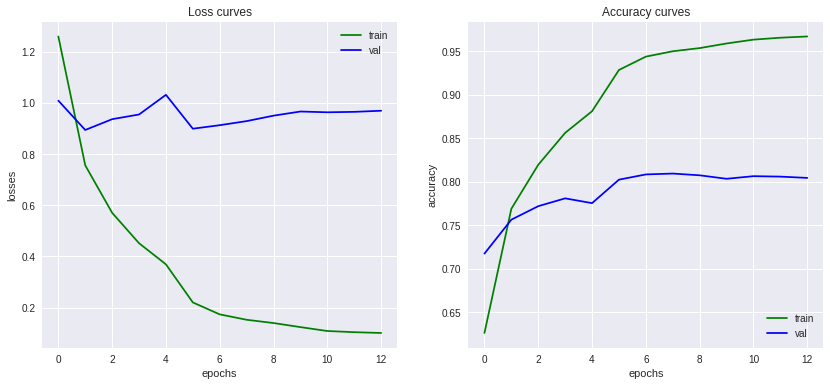

('n_min_valid_set', 128)
('n_test_set', 0)
('shuffle_before_split', True)
('use_norm', True)
('use_bad_sample_removal', True)
('use_rotate', False)
('use_rotate2', True)
('use_noising', False)
('use_fliplr', True)
('batch_size', 128)
('trainer', 'YQ')
('max_epochs', 30)
('early_stopping', True)
('epoch_patience', 5)
('auto_load_best_after_train', True)
('auto_save_interval', 5)
('show_live_progress', True)
('best_acc_train', 0.9670873941524205)
('best_acc_val', 0.8095)
('time_elapsed', 1377.4413793087006)
('early_stopped', 7)
('epoch_passed', 13)


In [69]:
# you can put many models into a list so that they can be trained one after
# another.
# you can even assign different train / valid split for different models
#
'''
models = [Net5(0.5), Net5(0.5), Net5(0.5), 
          Net5(0.45), Net5(0.45), Net5(0.45),
          Net5(0.55), Net5(0.55), Net5(0.55)
         ]
'''
# currently, we focused on single model `Net6`.
# models = [Net6([32, 64, 128, 256, 256], p_fc = 0.2, p_conv = 0.2)]

models = [Net5(p_fc = 0.5, channels = [32, 64, 128, 128, 128])]

#models = [MyResNet(MyBlock, [2,1,0,0], [16, 64, 128, 256, 512], p = 0.0)]
caches = []

train_config = {
    "n_min_valid_set": 128,
    "n_test_set": 0,
    "shuffle_before_split": True,
    "use_norm": True, # use_normalization,
    "use_bad_sample_removal": True, # use_bad_samples_removal,
    "use_rotate": False, # use_augment_with_rotate,
    "use_rotate2": True, # use_augment_with_rotate2,
    "use_noising": False, #use_augment_with_noise,
    "use_fliplr": True, #use_augment_with_fliplr,
    "batch_size": 128,
    "trainer": "YQ",
    "max_epochs": 30,
    "early_stopping": True,
    "epoch_patience": 5,
    "auto_load_best_after_train": True,
    "auto_save_interval": 5,
    "show_live_progress": True
}

debug("global training configuration: ")
for item in train_config.items():
    debug(item)


# apply different train / val split for different models
n_valid_sample = [2000] * len(models)
# or set different number of validate set like:
# n_valid_sample = [1500, 1000, 500, 2000, 1500... ] 
#[15000, 500, 500, 500, 500, 1000, 1000, 1000, 1000, 1000]
# minimal smple number for validating

# MAKE SURE USE THE SAME CONDITION ON TEST DATASET.
if train_config["use_norm"]:
    X_resized = normalize_dataset(X_resized)
    
# all training samples are in total_set
total_set = np.concatenate((X_resized, image_labels.reshape(-1, 1)), axis = 1)
if train_config["use_bad_sample_removal"]:
    total_set = wash_samples(total_set)

if train_config["shuffle_before_split"]:
    np.random.shuffle(total_set) # not need this?

# split the total dataset to train_valid and test set.
n_total_set = total_set.shape[0]
test_start = n_total_set - train_config["n_test_set"]

# load pre-processed train data as a whole train_valid_test set.
debug("reserve {} samples for testing".format(train_config["n_test_set"]))
train_valid_set = total_set[:n_total_set - train_config["n_test_set"],:]
test_set = None
if train_config["n_test_set"] > 0:
    test_set = total_set[n_total_set - train_config["n_test_set"]:,:]
    
# training each model
for i, model in enumerate(models):
    
    debug("\n================== model{}: {} ================== ".format(
        i, type(model).__name__))
 
    hp_params = {
        "model_name": type(model).__name__,
        "lr": 1e-3,
        "weight_decay": 0,
        "n_test_set": train_config["n_test_set"],
        "dropout_p": model.dropout_p,
        "dropout_conv_p": model.dropout_conv_p,
    }
    
    # loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = hp_params["lr"], 
                           weight_decay = hp_params["weight_decay"])
    #scheduler = lr_scheduler.StepLR(optimizer, 
    #                                step_size = 5, 
    #                                gamma = 0.5)

    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # Decay lr: first 10 epochs: 1e-3, last 10 epochs 1e-5, in middle: 1e-4
    scheduler = lr_scheduler.MultiStepLR(
        optimizer,  
        milestones = [5,10,15,train_config["max_epochs"]-5], 
        gamma = 0.1)
    
    suffix = "_" + train_config["trainer"] + "_" + str(i)
    debug('training model: {}, lr: {}, weight_decay:{}'.format(
        model.get_name(suffix), 
        optimizer.param_groups[0]['lr'], 
        optimizer.param_groups[0]['weight_decay']))
    
    if train_config["shuffle_before_split"]:
        debug("shuffling train_valid_set before splitting... ", end = "")
        np.random.shuffle(train_valid_set)
        debug("complete.")
    
    # reload train_valid_set from total_set
    train_valid_set = total_set[:n_total_set - train_config["n_test_set"],:]
    
    # split dataset to train / valid sets
    n_train_valid_set = train_valid_set.shape[0]
    cur_valid_sample = max(n_valid_sample[i], train_config["n_min_valid_set"])
    hp_params["n_valid_set"] = cur_valid_sample

    train_set = train_valid_set[0: -cur_valid_sample,:]
    valid_set = train_valid_set[-cur_valid_sample: ,:]
 
    debug("split train_valid_set to {} / {} samples".format(
        n_train_valid_set - cur_valid_sample, cur_valid_sample))
    
    #view_data_distribution(valid_set[:,-1], "valid_set", int_to_label)

    
    # data augmentation on training set
    augmented_train_set_list = []
    if train_config["use_rotate"]:
        augmented_train_set_list.append(augment_with_rotate(train_set))
    if train_config["use_rotate2"]:
        augmented_train_set_list.append(augment_with_rotate2(train_set))
    if train_config["use_noising"]:
        for i in range(4):
            augmented_train_set_list.append(augment_with_noise(train_set))
    if train_config["use_fliplr"]:
        augmented_train_set_list.append(augment_with_fliplr(train_set))
        
    for augmented_train_set in augmented_train_set_list:
        train_set = np.concatenate((train_set, augmented_train_set), axis = 0)

    n_train_set = train_set.shape[0]
    hp_params["n_train_set"] = n_train_set
    
    np.random.shuffle(train_set)
    #view_data_distribution(train_set[:,-1], "train_set", int_to_label)
    
    # build new train_valid_set by merging train set with valid set
    train_valid_set = np.concatenate((train_set, valid_set), axis = 0)
    
    # set model save path
    best_model_path = './models/best_model_' + model.get_name(suffix)
    auto_save_path = './models/auto_save_' + model.get_name(suffix)
    
    # pre-trained model from file
    # careful: this may cause model saw samples in validating set.
    # must NOT use pre-trained model if whole train / valid set si shuffled
    #model = load_model(model, best_model_path, auto_save_path)
    
    model.to(device)
    model.train()
    
    debug("train_set size:{}, valid_set size:{}".format(
        hp_params["n_train_set"], hp_params["n_valid_set"]))
    
    # perform training process
    model, loss, accuracies, train_result = train_model(
        model, 
        train_valid_set,
        criterion, 
        optimizer, 
        n_valid_sample = cur_valid_sample,
        scheduler = scheduler, 
        max_epochs = train_config["max_epochs"],
        early_stopping = train_config["early_stopping"],
        epoch_patience = train_config["epoch_patience"],
        auto_load_best_after_train = train_config["auto_load_best_after_train"],
        auto_save_path = auto_save_path, 
        best_model_path = best_model_path,
        auto_save_interval = train_config["auto_save_interval"],
        batch_size = train_config["batch_size"],
        show_live_progress = train_config["show_live_progress"]
    )
    caches.append(train_result)
    
    show_learning_curve(loss, accuracies)  
    for item in train_config.items():
        debug(item)
    for item in train_result.items():
        debug(item)

In [70]:
# view model architecture and their best accuracies on validate dataset.
for cache in caches:
    print(cache.items())

dict_items([('best_acc_train', 0.9670873941524205), ('best_acc_val', 0.8095), ('time_elapsed', 1377.4413793087006), ('early_stopped', 7), ('epoch_passed', 13)])


## 11. Performance Analysis

In [71]:
# uncomment and run this cell if you load models from model files
'''
trainers = ["YQ"]
models = [Net5(), Net5(0.45), Net5(0.55), 
          Net5(), Net5(0.45), Net5(0.55), 
          Net5(), Net5(0.45), Net5(0.55),
         ] * len(trainers)


for i, model in enumerate(models):
    for trainer in trainers:
        suffix = "_" + trainer + "_" + str(i)
        best_model_path = './models/best_model_' + model.get_name(suffix)
        auto_save_path = './models/auto_save_' + model.get_name(suffix)
        model = load_model(model, 
                           best_model_path = best_model_path,
                           auto_save_path = auto_save_path,
                           best_model_first = True,
                           ext = suffix)
'''

'\ntrainers = ["YQ"]\nmodels = [Net5(), Net5(0.45), Net5(0.55), \n          Net5(), Net5(0.45), Net5(0.55), \n          Net5(), Net5(0.45), Net5(0.55),\n         ] * len(trainers)\n\n\nfor i, model in enumerate(models):\n    for trainer in trainers:\n        suffix = "_" + trainer + "_" + str(i)\n        best_model_path = \'./models/best_model_\' + model.get_name(suffix)\n        auto_save_path = \'./models/auto_save_\' + model.get_name(suffix)\n        model = load_model(model, \n                           best_model_path = best_model_path,\n                           auto_save_path = auto_save_path,\n                           best_model_first = True,\n                           ext = suffix)\n'

In [0]:
def predict(model, test_X):
    """predict using a model on a dataset(test_X)
    params
        model: nn.Module
        test_X: dataset, narray (n_size, n_feature)
    returns
        predict_labels: prediction, list [n_size]
    """
    since = time.time()
    model.to(device)
    try:
        model.eval()   # Set model to evaluate mode
    except:
        pass
    predict_labels = []
    # Iterate over data.
    i = 0
    total = len(test_X)
    test_data = dataloader(phase = 'test', data_source = test_X)
    for batch_inputs in test_data:
        #debug(batch_inputs.shape)
        batch_inputs = batch_inputs.to(device)
        with torch.set_grad_enabled(False):
            batch_outputs = model(batch_inputs)
            batch_predict = torch.argmax(batch_outputs, dim = 1)
            batch_predict = batch_predict.cpu().numpy().tolist()
            predict_labels.extend(batch_predict)
            i += batch_inputs.size(0)
            print_progress(i / total)
    return predict_labels


def predicts_from_models(models, test_X):
    """return an ensemble predicts of all models on test_X
    params
        models: list [model]
        test_X: test set, narray (n_samples, n_features)
    returns
        predicts: narray (n_samples, len(models))
    """
    n_models = len(models)
    n_samples = test_X.shape[0]
    predicts = np.zeros((n_samples, n_models))
    for i, model in enumerate(models):
        predicts[:,i] = np.array(predict(model, test_X)).reshape(-1, )
    
    return predicts


def bagging(all_predicts):
    """giving a bagging predict based on all_predicts
    params
        all_predicts: narray (n_samples, n_models)
    returns
        voted_predict: list, 
    """
    n_samples, n_models = all_predicts.shape
    voted_predict = [None] * n_samples
    for i in range(n_samples):
        voted_predict[i] = np.argmax(np.bincount(all_predicts[i].astype(int)))
    return voted_predict


def bagging_from_models(models, test_X):
    """ensemble predic using bagging
    params
        models: list of model of nn.Module, [nn.Module]
        test_X: dataset, narray (n_size, n_feature)
    returns
        voted_predicted: prediction, list [n_size]
        predicts: predicts by all models, narray [n_size, len(models)]
    """
    predicts = predicts_from_models(models, test_X)
    voted_predict = bagging(predicts)   
    return voted_predict, predicts
    

def analysis_predict(true_labels, predict_labels, n_class = 31):
    """give an averate accuracy, show accuracies in each class.
    you can switch the values of the two parameters to see difference output
    params
        true_labels: narray (-1, ) or (-1, 1)
        predict_labels: narray (-1, ) or (-1, 1)
    returns
        average_accuracy
    """
    debug("Size: {}".format(len(true_labels)))
    class_correct = [0 for _ in range(n_class)]
    class_total = [0 for _ in range(n_class)]
    for i in range(len(predict_labels)):
        label_int = int(true_labels[i])
        class_correct[label_int] += (predict_labels[i] == label_int)
        class_total[label_int] += 1
        
    average_accuracy = sum(class_correct) / sum(class_total)
    print("Average accuracy: {:.2%}".format(average_accuracy))

    print("-"*32)
    for i in range(n_class):
        print("Accuracy of {:>12s}: {:.2%}".format(
            int_to_label[i], class_correct[i] / class_total[i]))

    return average_accuracy

**Test on reserved test set and show accuracy**

If you don't reserve test samples from the training dataset, skip the following cells in this section.

In [0]:
# using test_set
# test_set = total_set[n_test_set:,:]
if test_set is not None:
    test_inputs = test_set[:,:-1]
    test_labels = test_set[:, -1]
    debug(test_set.shape)
    test_predict_bagging, test_predicts_all = bagging_from_models(models, test_inputs)


In [0]:
#debug(test_predict_bagging[0:100])
#debug(test_predicts_all[0:30])

In [0]:
if test_set is not None:
    average_accuracy = analysis_predict(test_labels, test_predict_bagging)

In [0]:
if test_set is not None:
    view_data_distribution(test_predict_bagging, "test_predict", int_to_label)

In [0]:
if test_set is not None:
    show_images([test_set[:,:-1]], test_predict_bagging)

view mis-classified images

In [0]:
# view indices of misclassified images
if test_set is not None:
    is_correct = (np.array(test_predict_bagging) == test_labels)
    mis_indices = np.argwhere(is_correct == False).reshape(-1,)
    print(mis_indices)
    debug(len(mis_indices))

In [0]:
if test_set is not None:
    
    # show mis-classified images and predictions
    # this may takes some time to show all the images wrong classified.
    for id in mis_indices:
        debug("predicted:", int_to_label[test_predict_bagging[id]])
        show_images(test_set[:,0:-1], test_set[:,-1], id)
        print("-" * 20)

Same result by confusion_matrix from sklearn.

In [0]:
# show confusion matrix

from sklearn.metrics import confusion_matrix

if test_set is not None:
    cm = confusion_matrix(test_labels, test_predict_bagging)
    plt.imshow(cm)

#class_corrects = np.max(cm, axis = 1)
#class_totals = np.sum(cm, axis = 1)
#average_accuracy = np.sum(class_corrects) / np.sum(class_totals)
#accuracy = class_corrects / class_totals

#print("Average accuracy(valid) : {:.2%}".format(average_accuracy))
#print("-"*32)
#for i in range(n_class):
#    print("Accuracy of {:>12s}: {:.2%}".format(
#        int_to_label[i], accuracy[i] ))


## 12. Testing Models on Test Dataset

### loading test dataset

In [0]:
test_images = None
test_X_noise_reduced = None

In [0]:
test_image_data = np.load('./input/test_images.npy', encoding = 'latin1')
test_size, test_features = test_image_data.shape[0], len(test_image_data[0][1])

In [84]:
test_images = np.vstack(test_image_data[:,1]) # test_size, 100, 100
debug(test_images.shape)

(10000, 10000)


In [85]:
file_test_X_noise_reduced = './input/noise_reduced_test_X.npy'
test_X_noise_reduced = data_from_file(
    file_test_X_noise_reduced,
    "test_noise_reduced",
    reduce_noise,
    test_images)
   
debug(test_X_noise_reduced.shape)          

loading 'test_noise_reduced' from: './input/noise_reduced_test_X.npy'... successful.
shape of 'test_noise_reduced': (10000, 10000)
(10000, 10000)


### performing the same data pre-process procedure as train / val dataset

In [86]:
# make sure that both resized_test_X and resized_train_X are generated by
# the same data pre-processes.
OLD_IMG_SIZE = (100, 100)
NEW_IMG_SIZE = (30, 30)
file_test_X_resized = './input/resized_test_X.npy'

test_X_resized = resize_dataset(
    test_X_noise_reduced,
    old_size = OLD_IMG_SIZE,
    new_size = NEW_IMG_SIZE
)
use_normalization = True

# MAKE SURE USE THE SAME CONDITION ON TRAINING DATASET.
if use_normalization:
    test_X_resized = normalize_dataset(test_X_resized)

resizing images... 
progress:100.00% 0m27snormalizing data... complete.


id:2592


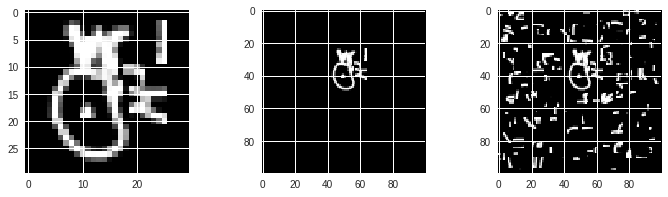

In [87]:
# before make prediction, let's see some test images
# re-run this cell to show different images on test dataset.
show_images([test_X_resized, test_X_noise_reduced, test_images], is_test = True)

In [0]:
# release memory, these instances are only used for display images.
test_images = None # release memory
test_X_noise_reduced = None # release memory

### loading models from file if necessary

In [89]:
# uncomment the following codes to load model from files
# make reasonable modification to these codes
'''
trainers = ["YQ"]
models = [Net5(), Net5(), Net5(), Net5(), Net5(), Net5(), Net5(), Net5(), 
          Net5(0.45), Net5(0.45), Net5(0.45), Net5(0.45), Net5(0.45), Net5(0.45),
          Net5(0.55), Net5(0.55), Net5(0.55), Net5(0.55), Net5(0.55), Net5(0.55)
         ]


for i, model in enumerate(models):
    for trainer in trainers:
        suffix = "_" + trainer + "_" + str(i)
        best_model_path = './models/best_model_' + model.get_name(suffix)
        auto_save_path = './models/auto_save_' + model.get_name(suffix)
        model = load_model(model, 
                           best_model_path = best_model_path,
                           auto_save_path = auto_save_path,
                           best_model_first = True,
                           ext = suffix)
        model.eval()
'''

'\ntrainers = ["YQ"]\nmodels = [Net5(), Net5(), Net5(), Net5(), Net5(), Net5(), Net5(), Net5(), \n          Net5(0.45), Net5(0.45), Net5(0.45), Net5(0.45), Net5(0.45), Net5(0.45),\n          Net5(0.55), Net5(0.55), Net5(0.55), Net5(0.55), Net5(0.55), Net5(0.55)\n         ]\n\n\nfor i, model in enumerate(models):\n    for trainer in trainers:\n        suffix = "_" + trainer + "_" + str(i)\n        best_model_path = \'./models/best_model_\' + model.get_name(suffix)\n        auto_save_path = \'./models/auto_save_\' + model.get_name(suffix)\n        model = load_model(model, \n                           best_model_path = best_model_path,\n                           auto_save_path = auto_save_path,\n                           best_model_first = True,\n                           ext = suffix)\n        model.eval()\n'

### predicting and bagging

In [90]:
# get all models' prediction on test dataset and their bagging prediction
predict_bagging, all_predicts = bagging_from_models(models, test_X_resized)
current_model_name = "bagging"

progress:100.00%

In [91]:
# view some prediction data
print(int_to_label)
print(predict_bagging[100:200])
len(predict_bagging)

{0: 'shovel', 1: 'rifle', 2: 'scorpion', 3: 'apple', 4: 'spoon', 5: 'pineapple', 6: 'mouth', 7: 'skateboard', 8: 'rollerskates', 9: 'peanut', 10: 'rabbit', 11: 'sink', 12: 'sailboat', 13: 'nose', 14: 'skull', 15: 'pool', 16: 'pear', 17: 'pillow', 18: 'penguin', 19: 'nail', 20: 'pencil', 21: 'empty', 22: 'octagon', 23: 'moustache', 24: 'paintbrush', 25: 'panda', 26: 'parrot', 27: 'screwdriver', 28: 'squiggle', 29: 'rhinoceros', 30: 'mug'}
[12, 28, 2, 21, 19, 3, 16, 30, 1, 23, 13, 6, 21, 10, 20, 0, 9, 1, 28, 21, 5, 12, 15, 23, 3, 13, 12, 15, 0, 30, 10, 17, 21, 24, 0, 12, 8, 2, 17, 12, 19, 2, 19, 15, 29, 25, 16, 13, 6, 20, 28, 1, 0, 23, 15, 19, 3, 4, 10, 22, 26, 13, 20, 15, 2, 18, 28, 21, 2, 22, 16, 1, 18, 9, 18, 19, 21, 23, 28, 29, 18, 12, 8, 5, 17, 19, 11, 12, 22, 21, 5, 2, 12, 11, 5, 14, 17, 0, 26, 6]


10000

image id:7072, class_id:23, class_label:moustache


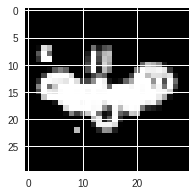

In [92]:
# show an image and corresponding bagging prediction
show_images([test_X_resized, test_X_noise_reduced, test_images], predict_bagging)

In [93]:
# view predicted label distribution
# check if they are similar to the train or valid dataset.
view_data_distribution(predict_bagging, "test predict", int_to_label)
#  special_labels = ['peanut', 'spoon', 'shovel', 'screwdriver', 'squiggle',
#                      'pencil']

Distribution of:  test predict
classes:31 total: 10000 (100%) 
--------------------------------
          shovel: 323 (3.23%)
           rifle: 422 (4.22%)
        scorpion: 340 (3.40%)
           apple: 352 (3.52%)
           spoon: 160 (1.60%)
       pineapple: 492 (4.92%)
           mouth: 569 (5.69%)
      skateboard: 406 (4.06%)
    rollerskates: 280 (2.80%)
          peanut: 259 (2.59%)
          rabbit: 345 (3.45%)
            sink: 259 (2.59%)
        sailboat: 396 (3.96%)
            nose: 193 (1.93%)
           skull: 291 (2.91%)
            pool: 435 (4.35%)
            pear: 176 (1.76%)
          pillow: 261 (2.61%)
         penguin: 324 (3.24%)
            nail: 342 (3.42%)
          pencil: 313 (3.13%)
           empty: 370 (3.70%)
         octagon: 450 (4.50%)
       moustache: 437 (4.37%)
      paintbrush: 275 (2.75%)
           panda: 180 (1.80%)
          parrot: 342 (3.42%)
     screwdriver: 198 (1.98%)
        squiggle: 255 (2.55%)
      rhinoceros: 179 (1.79%)
    

In [0]:
# you can also check a single model's prediction and predicted label
# distribution, uncomment next two lines

# single_predict = predict(models[0], test_X_resized)
# view_data_distribution(predict_bagging, "test predict", int_to_label)

### generate / load csv predict

In [0]:
# let's export our predictions to the csv file for submitting
# build a method for one prediction.
import csv
import glob

def predict_to_csv(predicts, file_path):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter = ',')
        writer.writerow(("Id", "Category"))
        for i, label in enumerate(predicts):
            writer.writerow((i, int_to_label[predicts[i]]))
    debug("save predict csv files of model: {} to: {}".format(
            current_model_name, file_path))
    
    
def predict_from_csv(csv_path, label_to_int):
    csv_data = np.genfromtxt(csv_path, names=True, delimiter=',',
                        dtype=[('Id', 'i8'), ('Category', 'S16')])
    debug("importing prediction from:{}... ".format(csv_path), end = "")
    predict = np.zeros((csv_data.shape[0], ), dtype = np.long)
    for i, predict_label in csv_data:
        predict_label = predict_label.decode("utf-8")
        predict[i] = label_to_int[predict_label]
    debug("complete.")
    return predict


def predicts_from_csvs(file_path, n_size, label_to_int):
    #file_path = "./candidates/top/*.csv"
    candidates = glob.glob(file_path)
    n_files = len(candidates)
    if n_files == 0:
        debug("No submission files found.")
        return None
    predicts = np.zeros((n_size, n_files))
    voted_predict = [None] * n_size

    for i, candidate in enumerate(candidates):
        predicts[:, i] = predict_from_csv(candidate, label_to_int)
    return predicts


def bagging_from_csvs(file_path, n_size, label_to_int):
    all_predicts = predicts_from_csvs(file_path, n_size, label_to_int)
    if all_predicts is None:
        return None, None
    voted_predict = bagging(all_predicts)
    return voted_predict, all_predicts    

# lazy_bagging: collect csv files to make bagging predcition, efficient way
# don't need to load models and generate predictions from them.
lazy_bagging = bagging_from_csvs 

In [96]:
voted_predict, all_predicts = bagging_from_csvs("./candidates/top/*csv", 10000, label_to_int)

importing prediction from:./candidates/top/lazy_bagging_result_great_than_83.csv... complete.
importing prediction from:./candidates/top/lazy_bagging_kaggle_83.40.csv... complete.
importing prediction from:./candidates/top/submission_83.00.csv... complete.
importing prediction from:./candidates/top/submission_83.40.csv... complete.
importing prediction from:./candidates/top/submission_83.00.1.csv... complete.
importing prediction from:./candidates/top/submission_83.33.1.csv... complete.
importing prediction from:./candidates/top/submission_80.44.csv... complete.
importing prediction from:./candidates/top/submission_82.58.csv... complete.
importing prediction from:./candidates/top/submission_82.80.csv... complete.
importing prediction from:./candidates/top/submission_83.58.csv... complete.
importing prediction from:./candidates/top/submission_84.15.csv... complete.
importing prediction from:./candidates/top/submission_83.87.csv... complete.
importing prediction from:./candidates/top/sub

In [97]:
view_data_distribution(voted_predict, "bagging from csvs", int_to_label)

Distribution of:  bagging from csvs
classes:31 total: 10000 (100%) 
--------------------------------
          shovel: 293 (2.93%)
           rifle: 461 (4.61%)
        scorpion: 365 (3.65%)
           apple: 358 (3.58%)
           spoon: 181 (1.81%)
       pineapple: 521 (5.21%)
           mouth: 565 (5.65%)
      skateboard: 416 (4.16%)
    rollerskates: 276 (2.76%)
          peanut: 213 (2.13%)
          rabbit: 370 (3.70%)
            sink: 262 (2.62%)
        sailboat: 415 (4.15%)
            nose: 191 (1.91%)
           skull: 292 (2.92%)
            pool: 473 (4.73%)
            pear: 175 (1.75%)
          pillow: 248 (2.48%)
         penguin: 368 (3.68%)
            nail: 362 (3.62%)
          pencil: 289 (2.89%)
           empty: 372 (3.72%)
         octagon: 456 (4.56%)
       moustache: 446 (4.46%)
      paintbrush: 312 (3.12%)
           panda: 189 (1.89%)
          parrot: 161 (1.61%)
     screwdriver: 158 (1.58%)
        squiggle: 214 (2.14%)
      rhinoceros: 214 (2.14%)

In [99]:
# saving bagging submisions
#average_accuracy = 1.0
file_path = 'submissions/submission_' + "bagging"
#file_path += '_{:.2f}'.format(100 * average_accuracy)
file_path += '.csv'
predict_to_csv(predict_bagging, file_path) 

save predict csv files of model: bagging to: submissions/submission_bagging.csv


In [100]:
# saving all single model submissions 
trainers = ["YQ"]
for i, model in enumerate(models):
    for trainer in trainers:
        suffix = "_" + trainer + "_" + str(i)
        current_model_name = model.get_name(suffix)
        file_path = 'submissions/submission_' + current_model_name
        #file_path += '_{:.2f}'.format(100 * average_accuracy)
        file_path += '.csv'
        predict_to_csv(all_predicts[:,i], file_path)  

save predict csv files of model: Net5_0.5_0.0__YQ_0 to: submissions/submission_Net5_0.5_0.0__YQ_0.csv


## All DONE!

### Contribution

**Jinfang Luo** designed and implemented `Linear SVM`,  and tested all the codes;

**Lifeng Wan** designed and implemented class: `DFS`,  function: `get_region_size`, `get_point_in_biggest_region`,  `find_max_connected_points`,  `normalize_dataset`,  `predict_from_csv`,  `predicts_from_csvs`,  `lazy_bagging`,  and tested all the codes.

**Qiang Ye** designed the architecture, implemented the rest codes, and wrote the documents and introduction



### License

BSD